In [47]:
import numpy as np
import torch as th
from torch import tensor
from torch.utils.data import TensorDataset
# Import dataloader
from torch.utils.data import DataLoader
import torch.nn.functional as F
from utils import randexclude
import networkx as nx
from matplotlib import pyplot

# Toy dataset from Decision Transformer (Chen et. al 2021)
class RandomWalks:
    def __init__(self, n_nodes=20, max_length=10, n_walks=1000, p_edge=0.1, seed=1002):
        self.n_nodes = n_nodes
        self.n_walks = n_walks
        self.max_length = max_length
        self.walk_size = max_length
        rng = np.random.RandomState(seed)

        walks, rewards = [], []
        while True:
            self.adj = rng.rand(n_nodes, n_nodes) > (1 - p_edge)
            np.fill_diagonal(self.adj, 0)
            if np.all(self.adj.sum(1)): break

        # terminal state
        self.adj[0, :] = 0
        self.adj[0, 0] = 1

        self.goal = 0
        for _ in range(n_walks):
            node = randexclude(rng, n_nodes, self.goal)
            walk = [node]

            for istep in range(max_length-1):
                node = rng.choice(np.nonzero(self.adj[node])[0])
                walk.append(node)
                if node == self.goal:
                    break

            r = th.zeros(max_length-1)
            r[:len(walk)-1] = -1 if walk[-1] == self.goal else -100

            rewards.append(r)
            walks.append(walk)

        states = []
        attention_masks = []

        for r, walk in zip(rewards, map(th.tensor, walks)):
            attention_mask = th.zeros(max_length, dtype=int)
            attention_mask[:len(walk)] = 1

            attention_masks.append(attention_mask)
            states.append(F.pad(walk, (0, max_length-len(walk))))

        self.worstlen = self.max_length
        self.avglen = sum(map(len, walks)) / self.n_walks
        self.bestlen = 0
        g = nx.from_numpy_array(self.adj, create_using=nx.DiGraph)
        for start in set(range(self.n_nodes)) - {self.goal}:
            try:
                shortest_path = nx.shortest_path(g, start, self.goal)[:self.max_length]
                self.bestlen += len(shortest_path)
            except:
                self.bestlen += self.max_length

        self.bestlen /= self.n_nodes - 1

        print(f'{self.n_walks} walks of which {(np.array([r[0] for r in rewards])==-1).mean()*100:.0f}% arrived at destination')

        # disallows selecting unaccessible nodes in a graph
        self.logit_mask = tensor(~self.adj)

        self.dataset = TensorDataset(th.stack(states), th.stack(attention_masks), th.stack(rewards))
        self.eval_dataset = TensorDataset(th.arange(1, self.n_nodes).unsqueeze(1))

    def render(self):

        g = nx.from_numpy_array(self.adj, create_using=nx.DiGraph)
        pos = nx.spring_layout(g, seed=7357)

        pyplot.figure(figsize=(10, 8))
        nx.draw_networkx_edges(g, pos=pos, alpha=0.5, width=1, edge_color='#d3d3d3')
        nx.draw_networkx_nodes(g, nodelist=set(range(len(self.adj))) - {self.goal}, pos=pos, node_size=300, node_color='orange')
        nx.draw_networkx_nodes(g, nodelist=[self.goal], pos=pos, node_size=300, node_color='darkblue')
        pyplot.show()

    def eval(self, samples, beta):
        narrived = 0
        actlen = 0
        for node in range(self.n_nodes-1):
            for istep in range(self.max_length):
                if samples[node, istep] == self.goal:
                    narrived += 1
                    break

            actlen += (istep + 1) / (self.n_nodes - 1)

        current = (self.worstlen - actlen)/(self.worstlen - self.bestlen)
        average = (self.worstlen - self.avglen)/(self.worstlen - self.bestlen)

        stats = { 'actlen': actlen,
                  'avglen': self.avglen,
                  'bestlen': self.bestlen,
                  'worstlen': self.worstlen,
                  'arrived': f'{narrived / (self.n_nodes-1) * 100:.0f}%',
                  'optimal': f'{current*100:.0f}% > {average*100:.0f}%' }

        return -actlen, stats

In [48]:
import torch
from torch.utils.data import Dataset
from transformer_lens import HookedTransformer, HookedTransformerConfig

class VariableLengthInterleavedDataset(Dataset):
    def __init__(self, original_dataset, goal_node):
        self.data = []
        self.goal_node = goal_node

        for tokens, _, rewards in original_dataset:
            # Extract actions (ignore the first token as it doesn't have a preceding reward)
            actions = tokens[1:]

            # Generate interleaved sequences of increasing lengths
            for i in range(1, len(rewards) + 1):
                # Check if the goal node is reached in this subsequence
                if actions[i-1] == self.goal_node:
                    # Cut off the sequence at the goal node
                    actions = actions[:i]
                    rewards = rewards[:i]
                    break

                # Create interleaved sequence with rewards up to i-th and actions up to (i-1)-th
                if i == 1:
                    # Special case for the first reward, no preceding action
                    interleaved = torch.tensor([rewards[0].item()], dtype=torch.long)
                else:
                    interleaved = torch.stack((rewards[:i].flatten(), actions[:i]), dim=1).flatten()

                # The target is the i-th action
                target = actions[i-1]

                if interleaved[:-1].shape[0] > 0:
                    self.data.append((interleaved[:-1], target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        interleaved, target = self.data[idx]
        length = interleaved.shape[0]  # Length of the original sequence
        return interleaved, target, length

# Initialize your RandomWalks dataset
data = RandomWalks(seed=3)
dataset = data.dataset
goal_node = data.goal
print(f"Goal node = {goal_node}")

# Use the original dataset to create the variable length interleaved dataset
variable_length_dataset = VariableLengthInterleavedDataset(dataset, goal_node)

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    interleaved, targets, lengths = zip(*batch)
    interleaved_padded = pad_sequence(interleaved, batch_first=True, padding_value=21)
    targets = torch.stack(targets)
    lengths = torch.tensor(lengths)  # Convert lengths to a tensor
    return interleaved_padded, targets, lengths


cfg = HookedTransformerConfig(
    d_model=128,
    d_head=64,
    n_heads=6,
    n_layers=2,
    n_ctx=40,
    d_vocab=21,
    attention_dir="causal",
    attn_only=True,
    #tokenizer_name="EleutherAI/gpt-neox-20b",
    seed=398,
    use_attn_result=True,
    positional_embedding_type="shortformer"
)

model = HookedTransformer(cfg)
device = 'mps'

batch_size = 128
variable_length_dataloader = DataLoader(variable_length_dataset, batch_size=batch_size, collate_fn=collate_fn)

device = 'mps'

for batch in variable_length_dataloader:
    interleaved, target, lengths = batch
    attention_mask = torch.arange(interleaved.size(1))[None, :] < lengths[:, None]  # Create attention mask
    attention_mask = attention_mask.to(device)

    interleaved = interleaved.long().to(device)
    target = target.to(device)

    outputs = model.forward(interleaved, attention_mask=attention_mask, return_type='logits')
    last_logits = outputs[torch.arange(outputs.size(0)), lengths - 1]

    # Ensure target is correctly sized for loss computation
    #target = target.squeeze()

    loss = F.cross_entropy(last_logits, target)

    print(f"Interleaved sequence = {interleaved}")
    print(f"outputs = {outputs}")
    print(f"last_logits = {last_logits}")
    print(f"target = {target}")
    print(f"Loss = {loss.item()}")
    break

1000 walks of which 51% arrived at destination
Goal node = 0
Interleaved sequence = tensor([[  -1,   12,   -1,  ...,   21,   21,   21],
        [  -1,   12,   -1,  ...,   21,   21,   21],
        [  -1,   12,   -1,  ...,   21,   21,   21],
        ...,
        [-100,   17, -100,  ..., -100,   19, -100],
        [-100,    5, -100,  ...,   21,   21,   21],
        [-100,    5, -100,  ...,   21,   21,   21]], device='mps:0')
outputs = tensor([[[ 1.2574e+00,  1.7896e-02, -5.4225e-01,  ..., -8.3437e-01,
          -2.8904e+00,  8.9747e-01],
         [ 1.0169e-01, -6.4097e-01, -6.0243e-01,  ..., -1.5053e+00,
          -1.9712e+00, -5.3021e-01],
         [ 3.7245e-01,  1.1329e-01, -6.7691e-01,  ..., -1.1946e+00,
          -2.2928e+00, -1.5587e-01],
         ...,
         [-1.7780e-01,  6.5782e-01, -1.4706e+00,  ...,  6.4006e-01,
          -9.1734e-01,  9.2261e-01],
         [-1.8996e-01,  6.7389e-01, -1.4628e+00,  ...,  7.0804e-01,
          -8.7424e-01,  9.4527e-01],
         [-1.7966e-01,  7

In [30]:
import torch
import torch.optim as optim
import torch.nn.functional as F

# Define the number of epochs and the optimizer
epochs = 10  # You can adjust the number of epochs based on your requirement
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Move the model to the appropriate device
model = model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in variable_length_dataloader:
        interleaved, target, lengths = batch
        attention_mask = torch.arange(interleaved.size(1))[None, :] < lengths[:, None]  # Create attention mask
        attention_mask = attention_mask.to(device)

        interleaved = interleaved.long().to(device)
        target = target.to(device)

        outputs = model.forward(interleaved, attention_mask=attention_mask, return_type='logits')
        last_logits = outputs[torch.arange(outputs.size(0)), lengths - 1]

        # Ensure target is correctly sized for loss computation
        #target = target.squeeze()

        loss = F.cross_entropy(last_logits, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(variable_length_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Moving model to device:  mps
Epoch 1/10, Loss: 0.5319
Epoch 2/10, Loss: 0.5058
Epoch 3/10, Loss: 0.4938
Epoch 4/10, Loss: 0.4889
Epoch 5/10, Loss: 0.4933
Epoch 6/10, Loss: 0.4861
Epoch 7/10, Loss: 0.4898
Epoch 8/10, Loss: 0.5009
Epoch 9/10, Loss: 0.5025
Epoch 10/10, Loss: 0.4916


In [55]:
import torch

def generate_sequences(model, starting_nodes, max_length, goal_node, device):
    model.eval()  # Set the model to evaluation mode
    sequences = []
    index_of_shortest_path = []
    g = nx.from_numpy_array(data.adj, create_using=nx.DiGraph)

    for start_node in starting_nodes:
        sequence = [torch.tensor([-1], dtype=torch.long).to(device), torch.tensor([start_node], dtype=torch.long).to(device)]  # Start with reward -1 and the starting node
        for _ in range(max_length):
            current_seq = torch.cat(sequence).unsqueeze(0).to(device)  # Prepare the sequence for the model
            seq_length = current_seq.size(1)

            # Create an attention mask for the current sequence
            attention_mask = torch.arange(seq_length).unsqueeze(0) < seq_length
            attention_mask = attention_mask.to(device)

            with torch.no_grad():
                output = model(current_seq, attention_mask=attention_mask, return_type='logits')  # Get model output
                next_action = torch.argmax(output[0, -1]).item()  # Choose the action with the highest probability
                # # Print the three most likely actions and their probabilities
                # top3_actions = torch.topk(output[0, -1], k=3)
                # top3_probs = torch.softmax(top3_actions.values, dim=-1)
                # #print(f"Top 3 actions = {top3_actions.indices}, probabilities = {top3_probs}")
                # # Print the shortest path action according to nx.shortest_path from the current node to goal node
                # shortest_path_action = nx.shortest_path(g, sequence[-1].item(), goal_node)[1]
                # #print(f"Shortest path action = {shortest_path_action}")
                # # Determine the ranking of the shortest path action in the output logits
                # # Get the indices of logits in decreasing order
                # sorted_indices = torch.argsort(output[0, -1], descending=True)
                # # Get the index of the shortest path action
                # shortest_path_action_index = torch.where(sorted_indices == shortest_path_action)[0].item()
                # #print(f"Shortest path action index = {shortest_path_action_index}")
                # index_of_shortest_path.append(shortest_path_action_index)

            sequence.append(torch.tensor([-1], dtype=torch.long).to(device))  # Append reward -1
            sequence.append(torch.tensor([next_action], dtype=torch.long).to(device))  # Append the predicted action

            if next_action == goal_node:
                break  # Stop if the goal node is reached

        sequences.append(torch.cat(sequence).cpu().numpy())  # Store the generated sequence

    #print(f"On average, the best move was at position {np.mean(index_of_shortest_path)}")

    return sequences

# Example usage
starting_nodes = [np.random.randint(1, data.n_nodes) for _ in range(5)]  # Replace 5 with the number of sequences you want to generate
max_length = 10  # Maximum length of the sequence
goal_node = data.goal
device = 'mps'  # or 'cpu', depending on your setup
generated_sequences = generate_sequences(model, starting_nodes, max_length, goal_node, device)

# Print generated sequences
for seq in generated_sequences:
    print(seq)

[-1 10 -1  5 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7]
[-1  1 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7]
[-1  9 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7]
[-1 10 -1  5 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7 -1  7]
[-1 11 -1 16 -1  0]


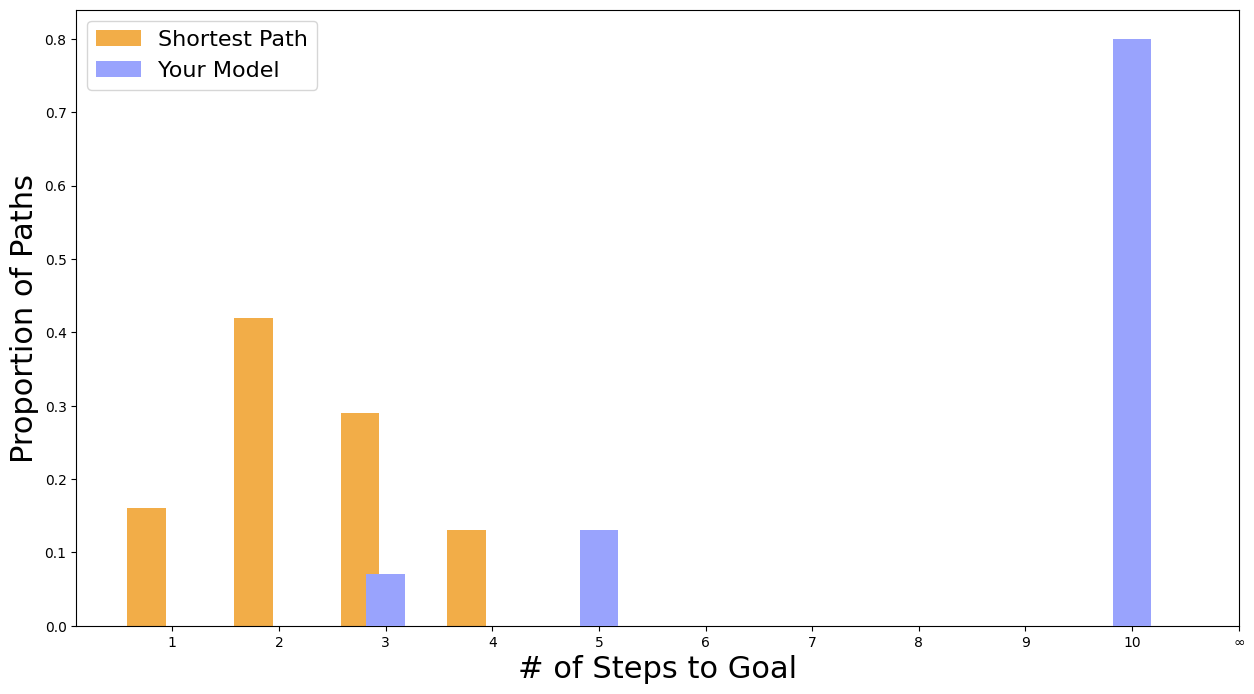

In [56]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Assuming 'data' and 'model' are already defined and the model is trained
# Assuming 'generate_sequences' is your sequence generation function

optimal_lengths = []
model_generated_lengths = []
random_walk_lengths = []
n_graphs = 100

# Optimal paths calculation
g = nx.from_numpy_array(data.adj, create_using=nx.DiGraph)
for _ in range(n_graphs):
    start = np.random.randint(1, data.n_nodes)
    if start != data.goal:
        try:
            shortest_path = nx.shortest_path(g, start, data.goal)
            optimal_lengths.append(len(shortest_path) - 1)
        except nx.NetworkXNoPath:
            optimal_lengths.append(data.max_length)

# Model-generated paths calculation
for i in range(n_graphs):
    start = np.random.randint(1, data.n_nodes)
    try:
        if start != data.goal:
            generated_seq = generate_sequences(model, [start], data.max_length, data.goal, device)[0]
            model_generated_lengths.append(np.where(generated_seq == data.goal)[0][0] if data.goal in generated_seq else data.max_length)
    except nx.NetworkXNoPath: 
        model_generated_lengths.append(data.max_length)

# Random walk paths calculation (if you have this data)
# ...

# Histogram and Plotting
plt.figure(figsize=(15, 8))

# Adjusted bin range
bins = np.arange(1, data.max_length + 2)

optimal_hist = np.histogram(optimal_lengths, bins=bins, density=True)[0]
model_generated_hist = np.histogram(model_generated_lengths, bins=bins, density=True)[0]
# random_walk_hist = ...  # If you have random walk data

x_ticks = np.arange(1, data.max_length + 1)

# Define bar size and colors
barsize = 0.36
opt_color = '#f2ad48'
model_color = '#99a3fd'
random_color = 'lightgray'

# Plotting histograms
plt.bar(x_ticks - barsize/1.5, optimal_hist, width=barsize, label='Shortest Path', color=opt_color, zorder=2)
plt.bar(x_ticks, model_generated_hist, width=barsize, label='Your Model', color=model_color, zorder=3)
# plt.bar(x_ticks + barsize/1.5, random_walk_hist, width=barsize, label='Random Walk', color=random_color, zorder=1)

plt.xticks(np.arange(1, data.max_length + 2), list(np.arange(1, data.max_length + 1)) + ['∞'])
plt.legend(fontsize=16)
plt.xlabel('# of Steps to Goal', fontsize=22)
plt.ylabel('Proportion of Paths', fontsize=22)

plt.savefig('graph_plot.svg')
plt.show()